# 🧍‍♂️ Pose Estimation with ViTPose 🧍‍♀️

Pose estimation is a powerful computer vision task focused on detecting and tracking human body keypoints (such as joints and limbs) from images or videos. 🧠📸  
It plays a crucial role in various domains such as:

- 🏋️‍♂️ Fitness & Training
- 🕺 Animation & VFX
- ⚽ Sports Analysis
- 🧑‍⚕️ Healthcare
- 🎮 Augmented Reality (AR)





![ViTPose Demo](https://github.com/janithaDassanayake/dummyimages/raw/main/ezgif-363d42dfc4201a.gif)




## ▶️ Run on Google Colab 😊

Click the badge below to open the full notebook in Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1JLM_ZkNvLc4GCQD0jSH0LS6LQa4xEObU)

> ⚡ **Tip:** Once opened, go to `File > Save a copy in Drive` to make your own editable version and start experimenting!

## 🚀 What is ViTPose?

**ViTPose** is a cutting-edge model built on **Vision Transformers (ViT)** for high-precision human pose estimation.  
It uses a **top-down keypoint detection** approach:

1. 🎯 **Detects human bounding boxes** (via an external detector like RT-DETR).
2. 🧩 **Estimates keypoints** for each individual separately.

This focused strategy ensures accurate keypoint detection even in crowded scenes.  
Thanks to the transformer’s self-attention mechanism, ViTPose effectively captures both **global context** and **local details**, leading to superior performance.


## 🧪 What You'll Learn in This Notebook

🔍 **Step-by-step pipeline using ViTPose on images:**
1. 👁️ Human detection with pre-trained **RT-DETR** from 🤗 Transformers.
2. 🧠 Keypoint inference with **ViTPose**.
3. 🖼️ Visualize human poses with keypoints overlay.


## 🎯 Why ViTPose?

- 📐 Transformer-based model for precise spatial understanding.
- 🤹 High performance in multi-person scenarios.
- 🔁 Generalizes well across different datasets and use cases.

## 📌 Let's Get Started!

You’ll be up and running with human pose estimation in just a few steps. Perfect for integrating into your own projects like:
- Personal training apps 💪
- Motion capture systems 🎞️
- Smart AR mirrors


## 🙌 Credits

- 🤗 [Hugging Face Transformers](https://huggingface.co) for RT-DETR  
- 🧠 [ViTPose Paper](https://arxiv.org/abs/2204.12484) for model architecture
- 🔧 Implementation credit to [@qubvel](https://github.com/qubvel) – for open-source work and code inspiration    

> Built with ❤️ to make human motion easier to understand.

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1w91jPhqwmft2tUr98fXd_3hmG1ztG4_x

!unzip ./Test_ViT_Pose.zip
!rm -f ./Test_ViT_Pose.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1w91jPhqwmft2tUr98fXd_3hmG1ztG4_x
To: /content/Test_ViT_Pose.zip
100% 7.38M/7.38M [00:00<00:00, 17.2MB/s]
Archive:  ./Test_ViT_Pose.zip
  inflating: Test_ViT_Pose/collage.jpeg  
  inflating: Test_ViT_Pose/pose (1).jpeg  
  inflating: Test_ViT_Pose/pose (1).mp4  
  inflating: Test_ViT_Pose/pose (2).jpeg  
  inflating: Test_ViT_Pose/pose (2).mp4  
  inflating: Test_ViT_Pose/pose (3).jpeg  
  inflating: Test_ViT_Pose/pose (3).mp4  


In [ ]:
# install the latest version
!pip install -U -q git+https://github.com/huggingface/transformers
!pip install -q supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
import torch
import moviepy
import argparse
import numpy as np
import supervision as sv
import huggingface_hub
import requests
from PIL import Image
from tqdm import tqdm

In [ ]:
from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from PIL import Image

# Load local image file
image = Image.open("/content/Test_ViT_Pose/collage.jpeg")
image.show()  # or display(image) if using Jupyter/Colab

## Run Pose Estimation

### Stage 1. Run Object Detector

Alright, once we’ve installed all the required dependencies and loaded the image, we can move on to using the RT-DETR (Real-Time Detection Transformer) model from Transformers. This model is designed specifically for fast and accurate object detection. Unlike traditional models that rely on extra steps like non-maximum suppression, RT-DETR simplifies the process by directly predicting the bounding boxes and their labels using a transformer-based approach. It's lightweight, accurate, and handles tough scenarios really well. We'll be using it here to detect human bounding boxes, which will act as the input for our next step — the ViTPose pose estimation model.

In [ ]:
# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes_xyxy = result["boxes"][result["labels"] == 0]
person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes = person_boxes_xyxy.copy()
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]
person_boxes

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

array([[2352.4944 ,   99.89178,  728.3779 , 1244.6521 ],
       [1305.2233 ,  172.89632,  623.4076 , 1124.8988 ],
       [ 150.05562,   98.53125,  889.3127 , 1235.5562 ]], dtype=float32)

### Stage 2. Run Keypoint detection with ViTPose

In [ ]:
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

# for vitpose-plus-base checkpoint we should additionaly provide dataset_index
# to sepcify which MOE experts to use for inference
if model.config.backbone_config.num_experts > 1:
    dataset_index = torch.tensor([0] * len(inputs["pixel_values"]))
    dataset_index = dataset_index.to(inputs["pixel_values"].device)
    inputs["dataset_index"] = dataset_index

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image

print(image_pose_result)

preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

[{'keypoints': tensor([[2718.4277,  214.0099],
        [2744.5366,  195.8251],
        [2692.1143,  188.3168],
        [2772.0554,  222.7699],
        [2647.4797,  209.8846],
        [2851.0576,  346.4409],
        [2548.9265,  357.2316],
        [3042.3970,  336.2611],
        [2393.2405,  470.5894],
        [2958.9387,  200.9775],
        [2560.8667,  591.8622],
        [2768.9890,  742.5604],
        [2621.2915,  738.0189],
        [2828.5342, 1085.7574],
        [2539.7654, 1062.1537],
        [2744.0437, 1349.0450],
        [2474.2937, 1347.0302]]), 'scores': tensor([0.9365, 1.0120, 0.9588, 0.9634, 0.9552, 0.9391, 0.9295, 1.0194, 0.9901,
        0.9832, 0.9894, 0.8123, 0.8227, 0.9814, 0.8814, 0.9295, 0.9538]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([2716.6833,  722.2178, 2721.5176,  728.9969])}, {'keypoints': tensor([[1621.2051,  274.9434],
        [1643.4053,  254.3158],
        [1597.8457,  253.4083],
        [1673.

In [ ]:
# print results in more human-readable format
for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")

Person #0
 - Nose: x=2718.43, y=214.01, score=0.94
 - L_Eye: x=2744.54, y=195.83, score=1.01
 - R_Eye: x=2692.11, y=188.32, score=0.96
 - L_Ear: x=2772.06, y=222.77, score=0.96
 - R_Ear: x=2647.48, y=209.88, score=0.96
 - L_Shoulder: x=2851.06, y=346.44, score=0.94
 - R_Shoulder: x=2548.93, y=357.23, score=0.93
 - L_Elbow: x=3042.40, y=336.26, score=1.02
 - R_Elbow: x=2393.24, y=470.59, score=0.99
 - L_Wrist: x=2958.94, y=200.98, score=0.98
 - R_Wrist: x=2560.87, y=591.86, score=0.99
 - L_Hip: x=2768.99, y=742.56, score=0.81
 - R_Hip: x=2621.29, y=738.02, score=0.82
 - L_Knee: x=2828.53, y=1085.76, score=0.98
 - R_Knee: x=2539.77, y=1062.15, score=0.88
 - L_Ankle: x=2744.04, y=1349.05, score=0.93
 - R_Ankle: x=2474.29, y=1347.03, score=0.95
Person #1
 - Nose: x=1621.21, y=274.94, score=0.96
 - L_Eye: x=1643.41, y=254.32, score=1.00
 - R_Eye: x=1597.85, y=253.41, score=0.96
 - L_Ear: x=1673.16, y=274.33, score=0.99
 - R_Ear: x=1564.05, y=272.76, score=0.97
 - L_Shoulder: x=1741.77, y=41

## Visualize results


To visualize the results, we'll use Supervision, a powerful library for annotating and rendering visual outputs in computer vision tasks. With Supervision, we can overlay detected bounding boxes from RT-DETR and keypoints from ViTPose directly on the input image, creating clear and intuitive visualizations. This helps us easily interpret the pose estimation results and validate the performance of the model. Let’s generate the visualizations to bring the predictions to life!

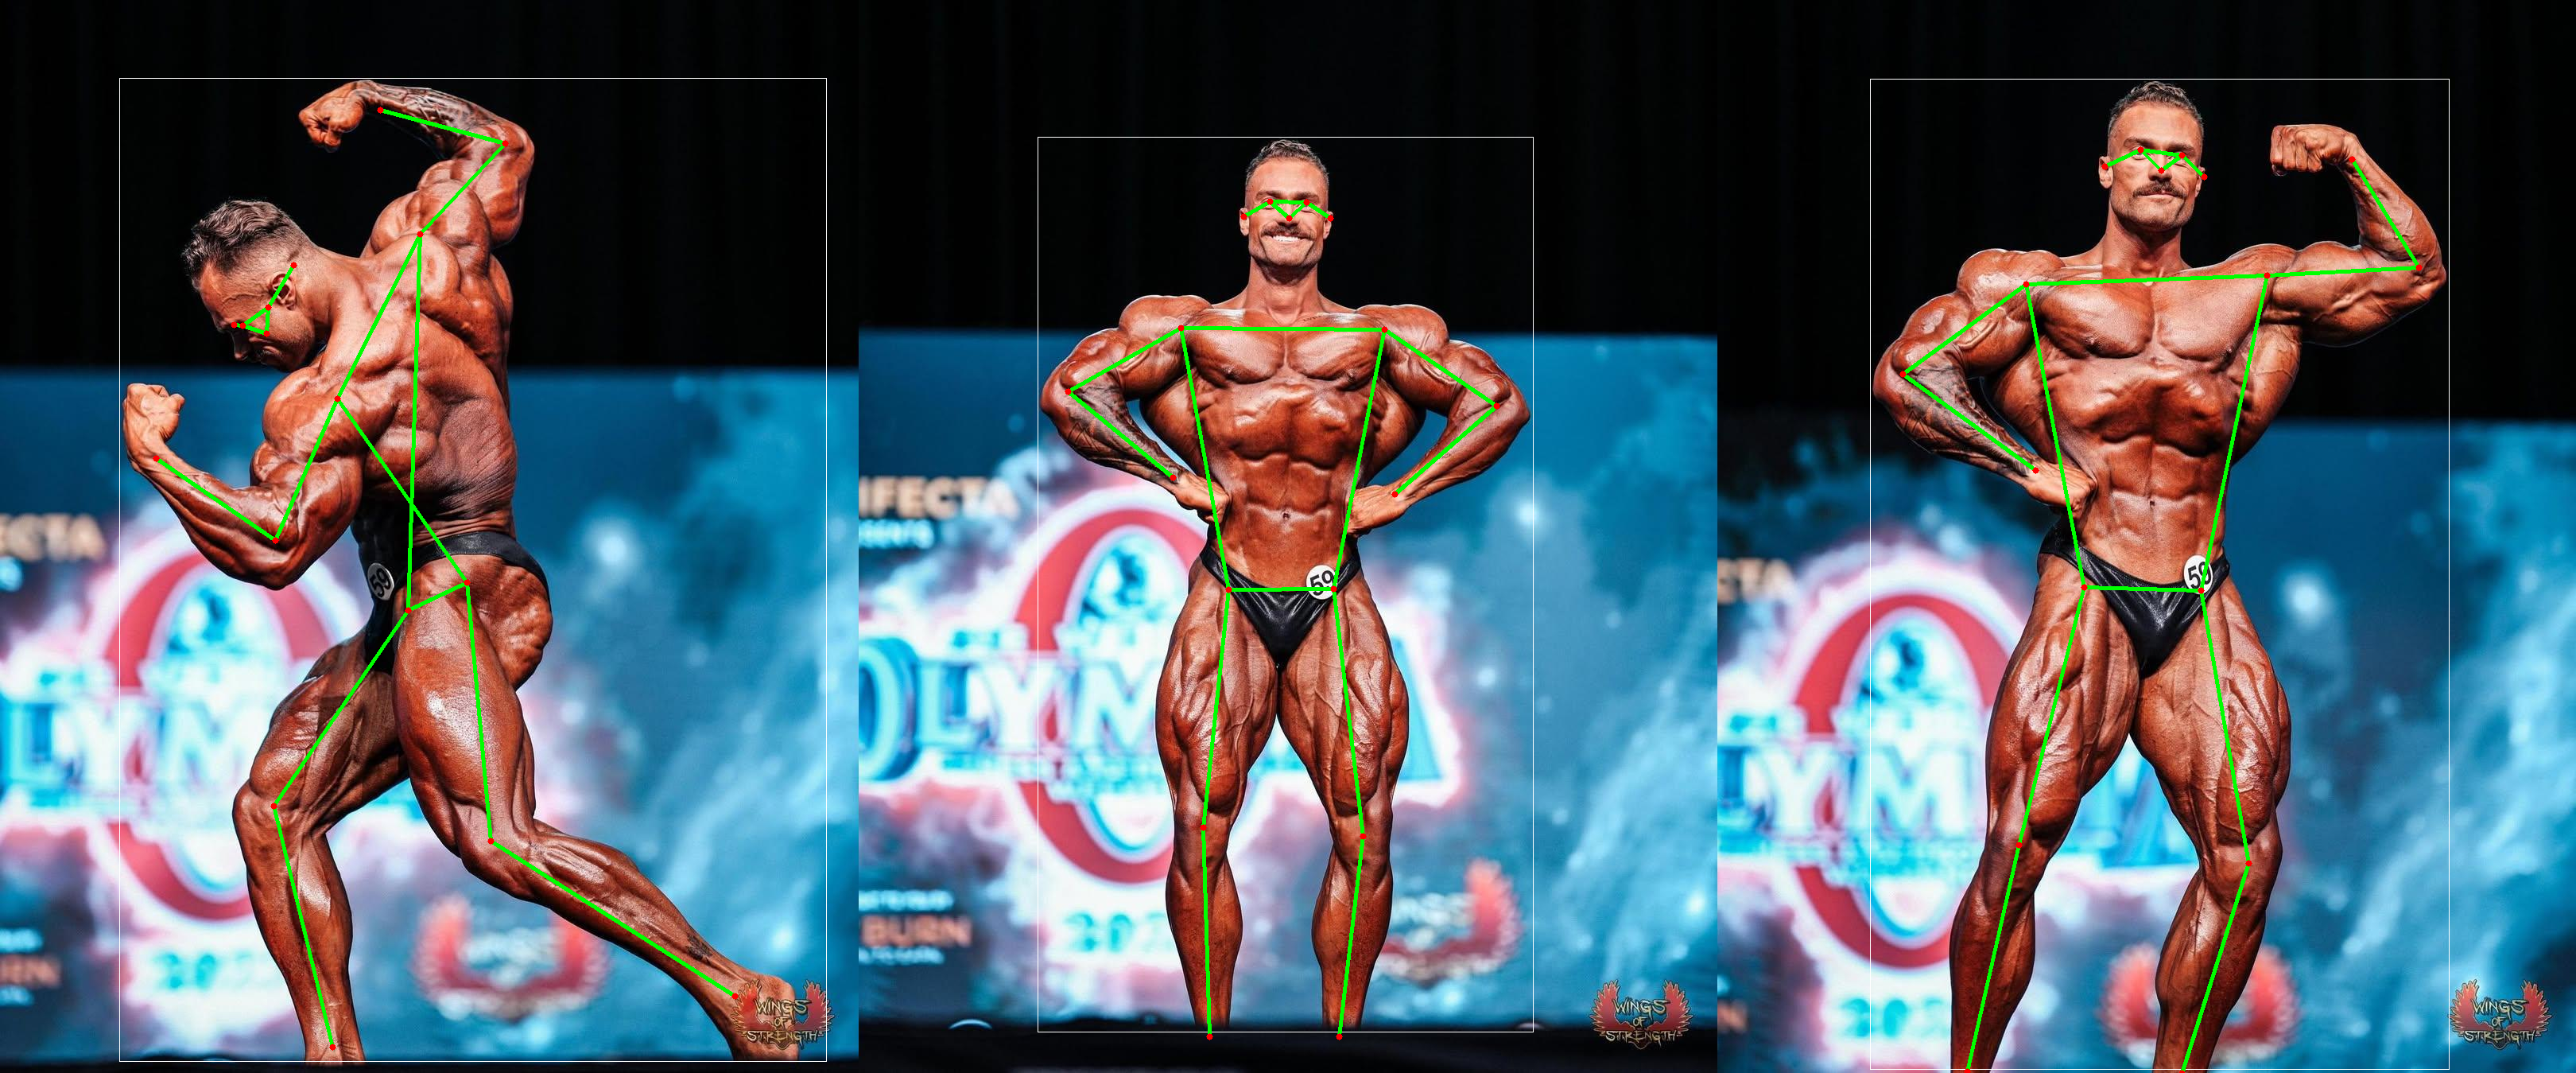

In [ ]:
import supervision as sv

# preprocess to torch tensor of shape (n_objects, n_keypoints, 2)
xy = [pose_result['keypoints'] for pose_result in image_pose_result]
xy = torch.stack(xy).cpu().numpy()

scores = [pose_result['scores'] for pose_result in image_pose_result]
scores = torch.stack(scores).cpu().numpy()

keypoints = sv.KeyPoints(xy=xy, confidence=scores)
detections = sv.Detections(xyxy=person_boxes_xyxy)

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=3)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.RED, radius=4)
bounding_box_annotator = sv.BoxAnnotator(
    color=sv.Color.WHITE, color_lookup=sv.ColorLookup.INDEX, thickness=1
)

annotated_frame = image.copy()

# annotate boundg boxes
annotated_frame = bounding_box_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

# annotate edges and verticies
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=keypoints
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=keypoints
)

annotated_frame

## Now Try with a demo Vide

In [ ]:
import torch
device = "cuda"

capability = torch.cuda.get_device_capability(device)
dtype = torch.bfloat16 if capability > (8, 0) else torch.float16

print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

Using device: cuda
Using dtype: torch.float16


In [ ]:
!pip install -U pip uv
!pip install -U git+https://github.com/qubvel/rt-pose.git
!uv pip install --system "moviepy==2.*" supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 113.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/qubvel/rt-pose.git to /tmp/pip-req-build-vt6mikuo
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/rt-pose.git /tmp/pip-req-build-vt6mikuo
  Resolved https://github.com/qubvel/rt-pose.git to commit b77635f4b9509fd2350baf1f73dca2737e853165
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 187.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from rt_pose import PoseEstimationPipeline, PoseEstimationOutput

In [ ]:
# Load pose estimation pipeline
pipeline = PoseEstimationPipeline(
    object_detection_checkpoint="PekingU/rtdetr_r34vd",
    pose_estimation_checkpoint="usyd-community/vitpose-plus-small",
    device="cuda",
    dtype=torch.float16,
    compile=True,  # True to get more speedup
)

2025-05-18 22:07:27.200 | INFO     | rt_pose.pipeline:_load_detector:70 - Loading detector from `PekingU/rtdetr_r34vd`...


config.json:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/126M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

2025-05-18 22:07:29.649 | INFO     | rt_pose.pipeline:_load_detector:74 - Detector loaded to `cuda` with dtype `torch.float16`!
2025-05-18 22:07:29.650 | INFO     | rt_pose.pipeline:_load_pose_estimator:79 - Loading pose estimator from `usyd-community/vitpose-plus-small`...


config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

2025-05-18 22:07:32.696 | INFO     | rt_pose.pipeline:_load_pose_estimator:83 - Pose estimator loaded to `cuda` with dtype `torch.float16`!
2025-05-18 22:07:32.696 | INFO     | rt_pose.pipeline:_compile_models:87 - Applying compilation to models...
2025-05-18 22:07:34.582 | INFO     | rt_pose.pipeline:_compile_models:90 - Model compilation is enabled, don't forget to call `pipeline.warmup()` method!
2025-05-18 22:07:34.583 | INFO     | rt_pose.pipeline:__init__:66 - Pipeline initialized successfully!


In [ ]:
# As you can see from logs below, model compilation is pretty long step.
# Compilation happens just-in-time, that is why we use warmup, to pass
# a few batches to the models to compile them.
pipeline.warmup()

2025-05-18 22:07:34.587 | INFO     | rt_pose.pipeline:warmup:215 - Running warmup for object detection step...
2025-05-18 22:09:08.590 | INFO     | rt_pose.pipeline:warmup:220 - Object detection step warmup took 94.00 seconds
2025-05-18 22:09:08.591 | INFO     | rt_pose.pipeline:warmup:222 - Running warmup for pose estimation step...
2025-05-18 22:10:52.870 | INFO     | rt_pose.pipeline:warmup:228 - Pose estimation step warmup took 104.28 seconds


## Defining some useful functions and loading demo clip

In [ ]:
import inspect
print(inspect.signature(pipeline.__call__))
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

(image: numpy.ndarray) -> rt_pose.pipeline.PoseEstimationOutput


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_clip(path):
    with open(path, "rb") as f:
        mp4 = f.read()
    data = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width=400 controls><source src={data} type="video/mp4"></video>')

def visualize_output(image: np.ndarray, output: PoseEstimationOutput, confidence: float = 0.3) -> np.ndarray:
    """
    Visualize pose estimation output.
    """
    keypoints_xy = output.keypoints_xy.float().cpu().numpy()
    scores = output.scores.float().cpu().numpy()

    # Supervision will not draw vertices with `0` score
    # and coordinates with `(0, 0)` value
    invisible_keypoints = scores < confidence
    scores[invisible_keypoints] = 0
    keypoints_xy[invisible_keypoints] = 0

    keypoints = sv.KeyPoints(xy=keypoints_xy, confidence=scores)

    _, y_min, _, y_max = output.person_boxes_xyxy.T
    height = int((y_max - y_min).mean().item())
    radius = max(height // 100, 4)
    thickness = max(height // 200, 2)
    edge_annotator = sv.EdgeAnnotator(color=sv.Color.YELLOW, thickness=thickness)
    vertex_annotator = sv.VertexAnnotator(color=sv.Color.ROBOFLOW, radius=radius)

    annotated_frame = image.copy()
    annotated_frame = edge_annotator.annotate(annotated_frame, keypoints)
    annotated_frame = vertex_annotator.annotate(annotated_frame, keypoints)

    return annotated_frame

In [ ]:
import cv2
from tqdm import tqdm

cap = cv2.VideoCapture("/content/Test_ViT_Pose/pose (1).mp4")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None

while True:
    ret, frame = cap.read()
    if not ret: break

    output = pipeline(frame)
    annotated = visualize_output(frame, output, confidence=0.3)

    if out is None:
        h, w = annotated.shape[:2]
        out = cv2.VideoWriter('annotated.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))

    out.write(annotated)

cap.release()
out.release()
